In [1]:
from netCDF4 import Dataset
import numpy as np

In [2]:
filename='Slab2Distribute_Mar2018/cas_slab2_dep_02.24.18.grd'
nc_fid=Dataset(filename,'r')

In [3]:
x = nc_fid.variables['x'][:]
y = nc_fid.variables['y'][:]
z = nc_fid.variables["z"][:]

In [4]:
nx = x.shape[0]
ny = y.shape[0]
xmin, xmax = x.min(), x.max()
ymin, ymax = y.min(), y.max()

In [5]:
mask = z.mask

x, y = np.meshgrid(x, y)
x = x[mask == False]
y = y[mask == False]
z = z[mask == False]

In [6]:
import matplotlib.pylab as plt

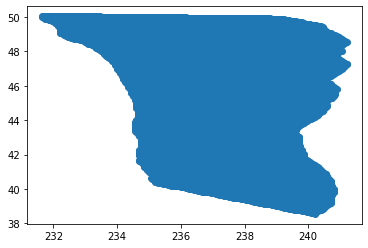

In [7]:
plt.scatter(x.flatten(), y.flatten())

In [8]:
from scipy.interpolate import griddata
from scipy.interpolate import interp2d

xi = np.linspace(xmin,xmax,nx)
yi = np.linspace(ymin,ymax,ny)
zi = griddata((x, y), z, (xi[None,:], yi[:,None]), method='nearest')

In [9]:
from skimage.filters import gaussian

for i in range(4):
    zi = gaussian(zi, sigma=5, preserve_range=True)

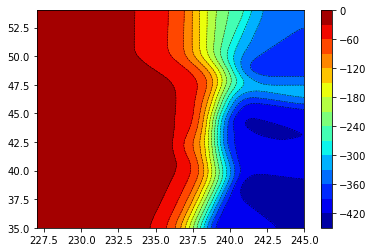

In [10]:
CS = plt.contour(xi,yi,zi,15,linewidths=0.5,colors='k')
CS = plt.contourf(xi,yi,zi,15,cmap=plt.cm.jet)
plt.colorbar() # draw colorbar
plt.show()

## Extract the contour of the slab

In [11]:
values = np.where(mask, 0, 1)

In [12]:
for val in range(4):
    values = gaussian(values, 3, preserve_range=True)

In [13]:
from skimage import measure

In [14]:
around = measure.find_contours(values, 0.5)

In [15]:
x = around[0][:,0]
y = around[0][:,1]
i = np.round(x).astype("int")
j = np.round(y).astype("int") 

## Mesh the extend of the slab


In [16]:

import gmsh
gmsh.initialize()
gmsh.model.add("test")

#gmsh.option.setNumber("Mesh.MeshSizeMax", 1)

In [17]:
pts_list = []
for idx in range(len(x)):
        pt = gmsh.model.geo.add_point(x[idx], y[idx], 0)
        pts_list.append(pt)
        
if pts_list:
    pts_list = pts_list + [pts_list[0]]
    line_list = []
    for idx in range(len(pts_list)-1):
        pt1 = pts_list[idx]
        pt2 = pts_list[idx+1]
        line_list.append(gmsh.model.geo.add_line(pt1, pt2))

In [18]:
cl = gmsh.model.geo.add_curve_loop(line_list)
gmsh.model.geo.add_plane_surface([cl])

1

In [19]:
gmsh.model.geo.synchronize()

In [20]:
gmsh.model.mesh.generate(2)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 10%] Meshing curve 12 (Line)
Info    : [ 10%] Meshing curve 13 (Line)
Info    : [ 10%] Meshing curve 14 (Line)
Info    : [ 10%] Meshing curve 15 (Line)
Info    : [ 10%] Meshing curve 16 (Line)
Info    : [ 10%] Meshing curve 17 (Line)
Info    : [ 10%] Meshing curve 18 (Line)
Info    : [ 10%] Meshing curve 19 (Line)
Info    : [ 10%] Meshing curve 20 (Line)
Info    : [ 10%] Meshing curve 21 (Line)
Info    : [ 10%] Meshing curve 22 (Line)
Info    : [ 10%] Meshing curve 23 (Line)
Info    : [ 10%] Meshing curve 24 (Line)
I

Info    : Done meshing 2D (Wall 2.30113s, CPU 2.29007s)
Info    : 69923 nodes 140719 elements


In [21]:
#gmsh.fltk.run()

## Advect Mesh in the z-direction

### Extract Nodes and elements

In [22]:
f = interp2d(np.arange(nx), np.arange(ny), zi)

In [23]:
nodeTags = {}
nodeCoords = {}
elementTypes = {}
elementTags = {}
elementNodeTags = {}

In [24]:
entities = gmsh.model.get_entities()

In [25]:
# get the nodes and elements
for e in entities:
    nodeTags[e], nodeCoords[e], _ = gmsh.model.mesh.getNodes(e[0], e[1])
    elementTypes[e], elementTags[e], elementNodeTags[e] = gmsh.model.mesh.getElements(e[0], e[1])

In [26]:
gmsh.model.mesh.clear()

### Advect and add elements

In [27]:
import numpy as np
import random
import math

for e in entities: 
    for i in range(2, len(nodeCoords[e]), 3):
        ii = nodeCoords[e][i-2]
        jj = nodeCoords[e][i-1]
        nodeCoords[e][i] = f(jj, ii)
    gmsh.model.mesh.addNodes(e[0], e[1], nodeTags[e], nodeCoords[e])
    gmsh.model.mesh.addElements(e[0], e[1], elementTypes[e], elementTags[e],
                               elementNodeTags[e])

In [28]:
gmsh.write("test_smooth1.vtk")

Info    : Writing 'test_smooth1.vtk'...
Info    : Done writing 'test_smooth1.vtk'


In [29]:
#gmsh.fltk.run()